# Convert CVAT Corrected Masks to .npy

Takes the ensemble prediction masks and merges in any corrected masks from CVAT,
then saves as `.npy` for the preprocessing pipeline.

**How it works**:
1. Load all ensemble masks from `cvat_export/` as the base (573 tiles)
2. If corrected masks exist, override those tiles with the corrected versions
3. Save as `(N, 1, 512, 512)` uint8 `.npy`

This means you can run it with **0 corrections** (just converts ensemble to npy),
or with a **partial subset** (e.g., 50 corrected out of 573).

**Classes (6-class ensemble)**:

| Value | Label |
|-------|-------|
| 0 | background |
| 1 | building |
| 2 | woodland |
| 3 | water |
| 4 | road |
| 5 | mangrove |

In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile

# ============================================================
# CONFIGURATION
# ============================================================

# Base ensemble masks (from inference notebook CVAT export)
ENSEMBLE_ZIP = Path("../data/cvat_export/cvat_ensemble_masks.zip")

# Corrected masks from CVAT (optional — can be empty)
CORRECTED_MASKS_DIR = Path("../data/cvat_export/corrected_masks")

# Original dataset (for images + shape reference)
ORIGINAL_IMAGES_NPY = Path("../data/0_5m/512dataset_images.npy")
ORIGINAL_LABELS_NPY = Path("../data/0_5m/512dataset_labels.npy")

# Output
OUTPUT_LABELS_NPY = Path("../data/0_5m/512dataset_labels_6class.npy")

CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road', 'mangrove']
NUM_CLASSES = 6

print(f"Ensemble ZIP: {ENSEMBLE_ZIP}")
print(f"Corrected masks: {CORRECTED_MASKS_DIR}")
print(f"Output: {OUTPUT_LABELS_NPY}")

Ensemble ZIP: ..\data\cvat_export\cvat_ensemble_masks.zip
Corrected masks: ..\data\cvat_export\corrected_masks
Output: ..\data\0_5m\512dataset_labels_6class.npy


## 1. Load ensemble masks as base

In [2]:
# Extract ensemble masks from the CVAT ZIP (SegmentationClass/)
ensemble_masks = {}

with zipfile.ZipFile(ENSEMBLE_ZIP, 'r') as zf:
    for entry in zf.namelist():
        if "SegmentationClass/" in entry and entry.endswith(".png"):
            name = Path(entry).stem  # e.g. 'tile_00042'
            mask = np.array(Image.open(zf.open(entry)))
            if mask.ndim == 3:
                mask = mask[:, :, 0]
            ensemble_masks[name] = mask

# Sort by name to get consistent ordering
tile_names = sorted(ensemble_masks.keys())
n_samples = len(tile_names)

print(f"Loaded {n_samples} ensemble masks from ZIP")
print(f"First 5: {tile_names[:5]}")
print(f"Mask shape: {ensemble_masks[tile_names[0]].shape}")
print(f"Unique values: {np.unique(ensemble_masks[tile_names[0]]).tolist()}")

Loaded 573 ensemble masks from ZIP
First 5: ['tile_00000', 'tile_00001', 'tile_00002', 'tile_00003', 'tile_00004']
Mask shape: (512, 512)
Unique values: [0, 1, 2, 3, 4, 5]


## 2. Merge corrected masks (if any)

In [3]:
# Check for corrected masks and override
corrected_files = sorted(CORRECTED_MASKS_DIR.glob("*.png")) if CORRECTED_MASKS_DIR.exists() else []
n_corrected = 0

for mask_path in corrected_files:
    name = mask_path.stem
    if name in ensemble_masks:
        mask = np.array(Image.open(mask_path))
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        ensemble_masks[name] = mask
        n_corrected += 1

print(f"Corrected masks found: {len(corrected_files)}")
print(f"Merged into ensemble: {n_corrected}")
print(f"Remaining from ensemble: {n_samples - n_corrected}")

# Build the label array: (N, 1, 512, 512) uint8
labels_array = np.zeros((n_samples, 1, 512, 512), dtype=np.uint8)

for i, name in enumerate(tqdm(tile_names, desc="Building array")):
    labels_array[i, 0] = ensemble_masks[name]

print(f"\nLabels array: {labels_array.shape}, dtype={labels_array.dtype}")
print(f"Unique values: {np.unique(labels_array).tolist()}")

# Class distribution
print(f"\nClass distribution:")
flat = labels_array.flatten()
for c in range(NUM_CLASSES):
    count = (flat == c).sum()
    pct = count / len(flat) * 100
    print(f"  {c} ({CLASS_NAMES[c]:12s}): {count:>12,} ({pct:>5.1f}%)")

Corrected masks found: 10
Merged into ensemble: 10
Remaining from ensemble: 563


Building array: 100%|██████████| 573/573 [00:00<00:00, 28602.97it/s]


Labels array: (573, 1, 512, 512), dtype=uint8


Unique values: [0, 1, 2, 3, 4, 5, 36, 52, 250, 255]

Class distribution:
  0 (background  ):   61,520,244 ( 41.0%)
  1 (building    ):    3,146,430 (  2.1%)
  2 (woodland    ):   16,033,249 ( 10.7%)
  3 (water       ):   27,496,229 ( 18.3%)
  4 (road        ):    1,689,375 (  1.1%)
  5 (mangrove    ):   40,001,624 ( 26.6%)


## 3. Save .npy

In [4]:
np.save(OUTPUT_LABELS_NPY, labels_array)

file_size_mb = OUTPUT_LABELS_NPY.stat().st_size / (1024**2)
print(f"Saved: {OUTPUT_LABELS_NPY} ({file_size_mb:.1f} MB)")
print(f"Shape: {labels_array.shape}")
print(f"\nTo use in preprocessing, update LABELS_FILE to point to:")
print(f"  {OUTPUT_LABELS_NPY.name}")

Saved: ..\data\0_5m\512dataset_labels_6class.npy (143.3 MB)
Shape: (573, 1, 512, 512)

To use in preprocessing, update LABELS_FILE to point to:
  512dataset_labels_6class.npy


## 4. Sanity check

Verified: (573, 1, 512, 512), dtype=uint8
Images:   (573, 3, 512, 512)


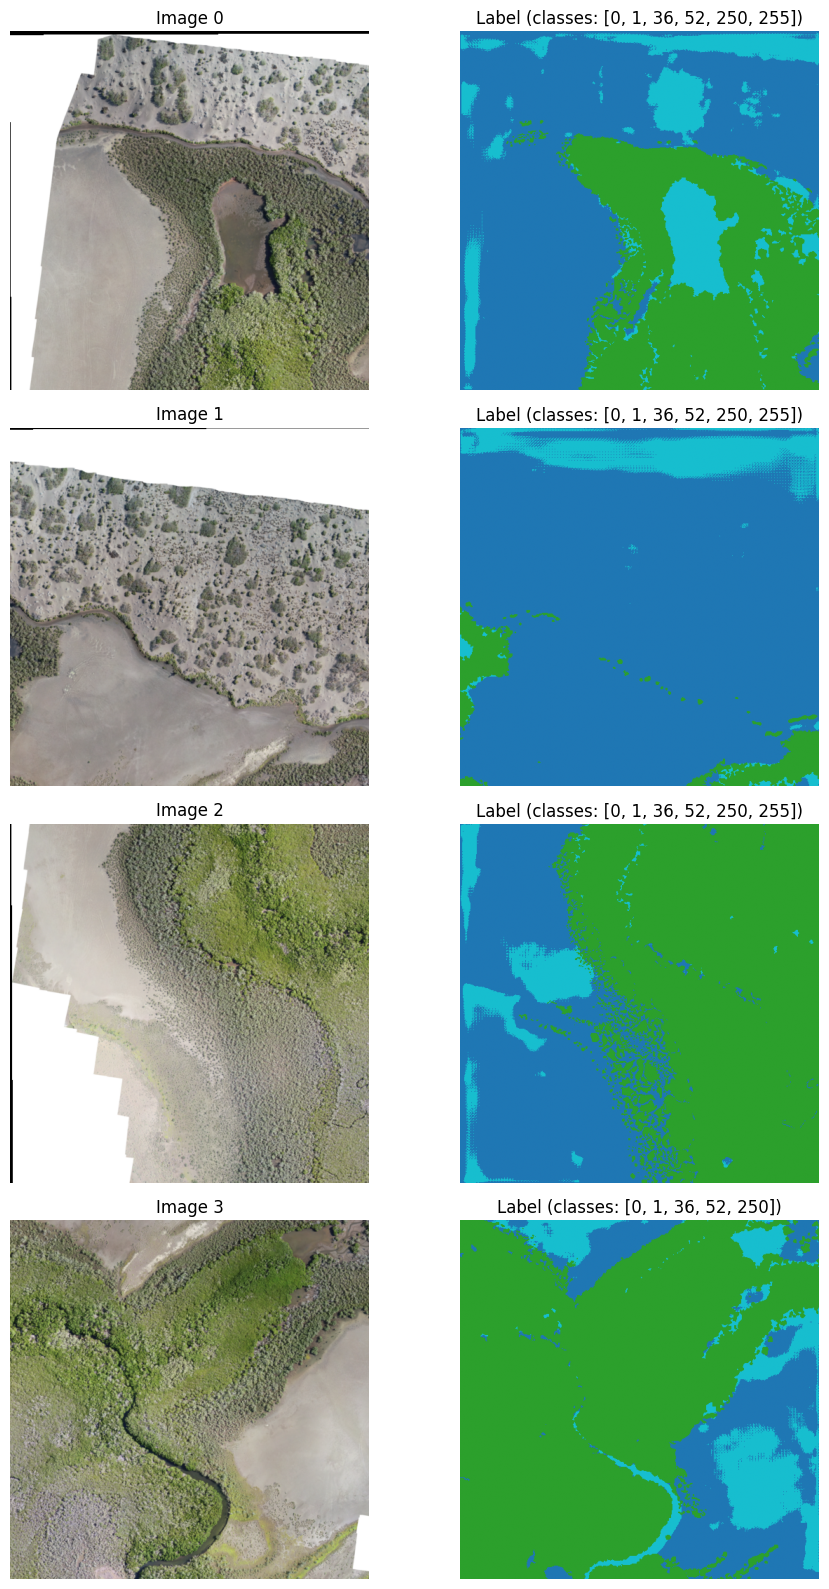

Done! 10 corrected + 563 ensemble = 573 total


In [5]:
# Reload and verify
verify = np.load(OUTPUT_LABELS_NPY, mmap_mode='r')
images = np.load(ORIGINAL_IMAGES_NPY, mmap_mode='r')

print(f"Verified: {verify.shape}, dtype={verify.dtype}")
print(f"Images:   {images.shape}")
assert verify.shape[0] == n_samples, "Sample count mismatch!"
assert verify.shape[2:] == (512, 512), "Tile size mismatch!"

# Show a few samples
n_show = min(4, len(verify))
fig, axes = plt.subplots(n_show, 2, figsize=(10, 4 * n_show))
if n_show == 1:
    axes = axes[np.newaxis, :]

for i in range(n_show):
    img = images[i]
    if img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image {i}")
    axes[i, 0].axis('off')

    lbl = verify[i].squeeze()
    axes[i, 1].imshow(lbl, vmin=0, vmax=5, cmap='tab10')
    axes[i, 1].set_title(f"Label (classes: {np.unique(lbl).tolist()})")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
print(f"Done! {n_corrected} corrected + {n_samples - n_corrected} ensemble = {n_samples} total")

## 5. Compare corrected vs original ensemble

Shows only tiles that were corrected: image | original ensemble | corrected | diff

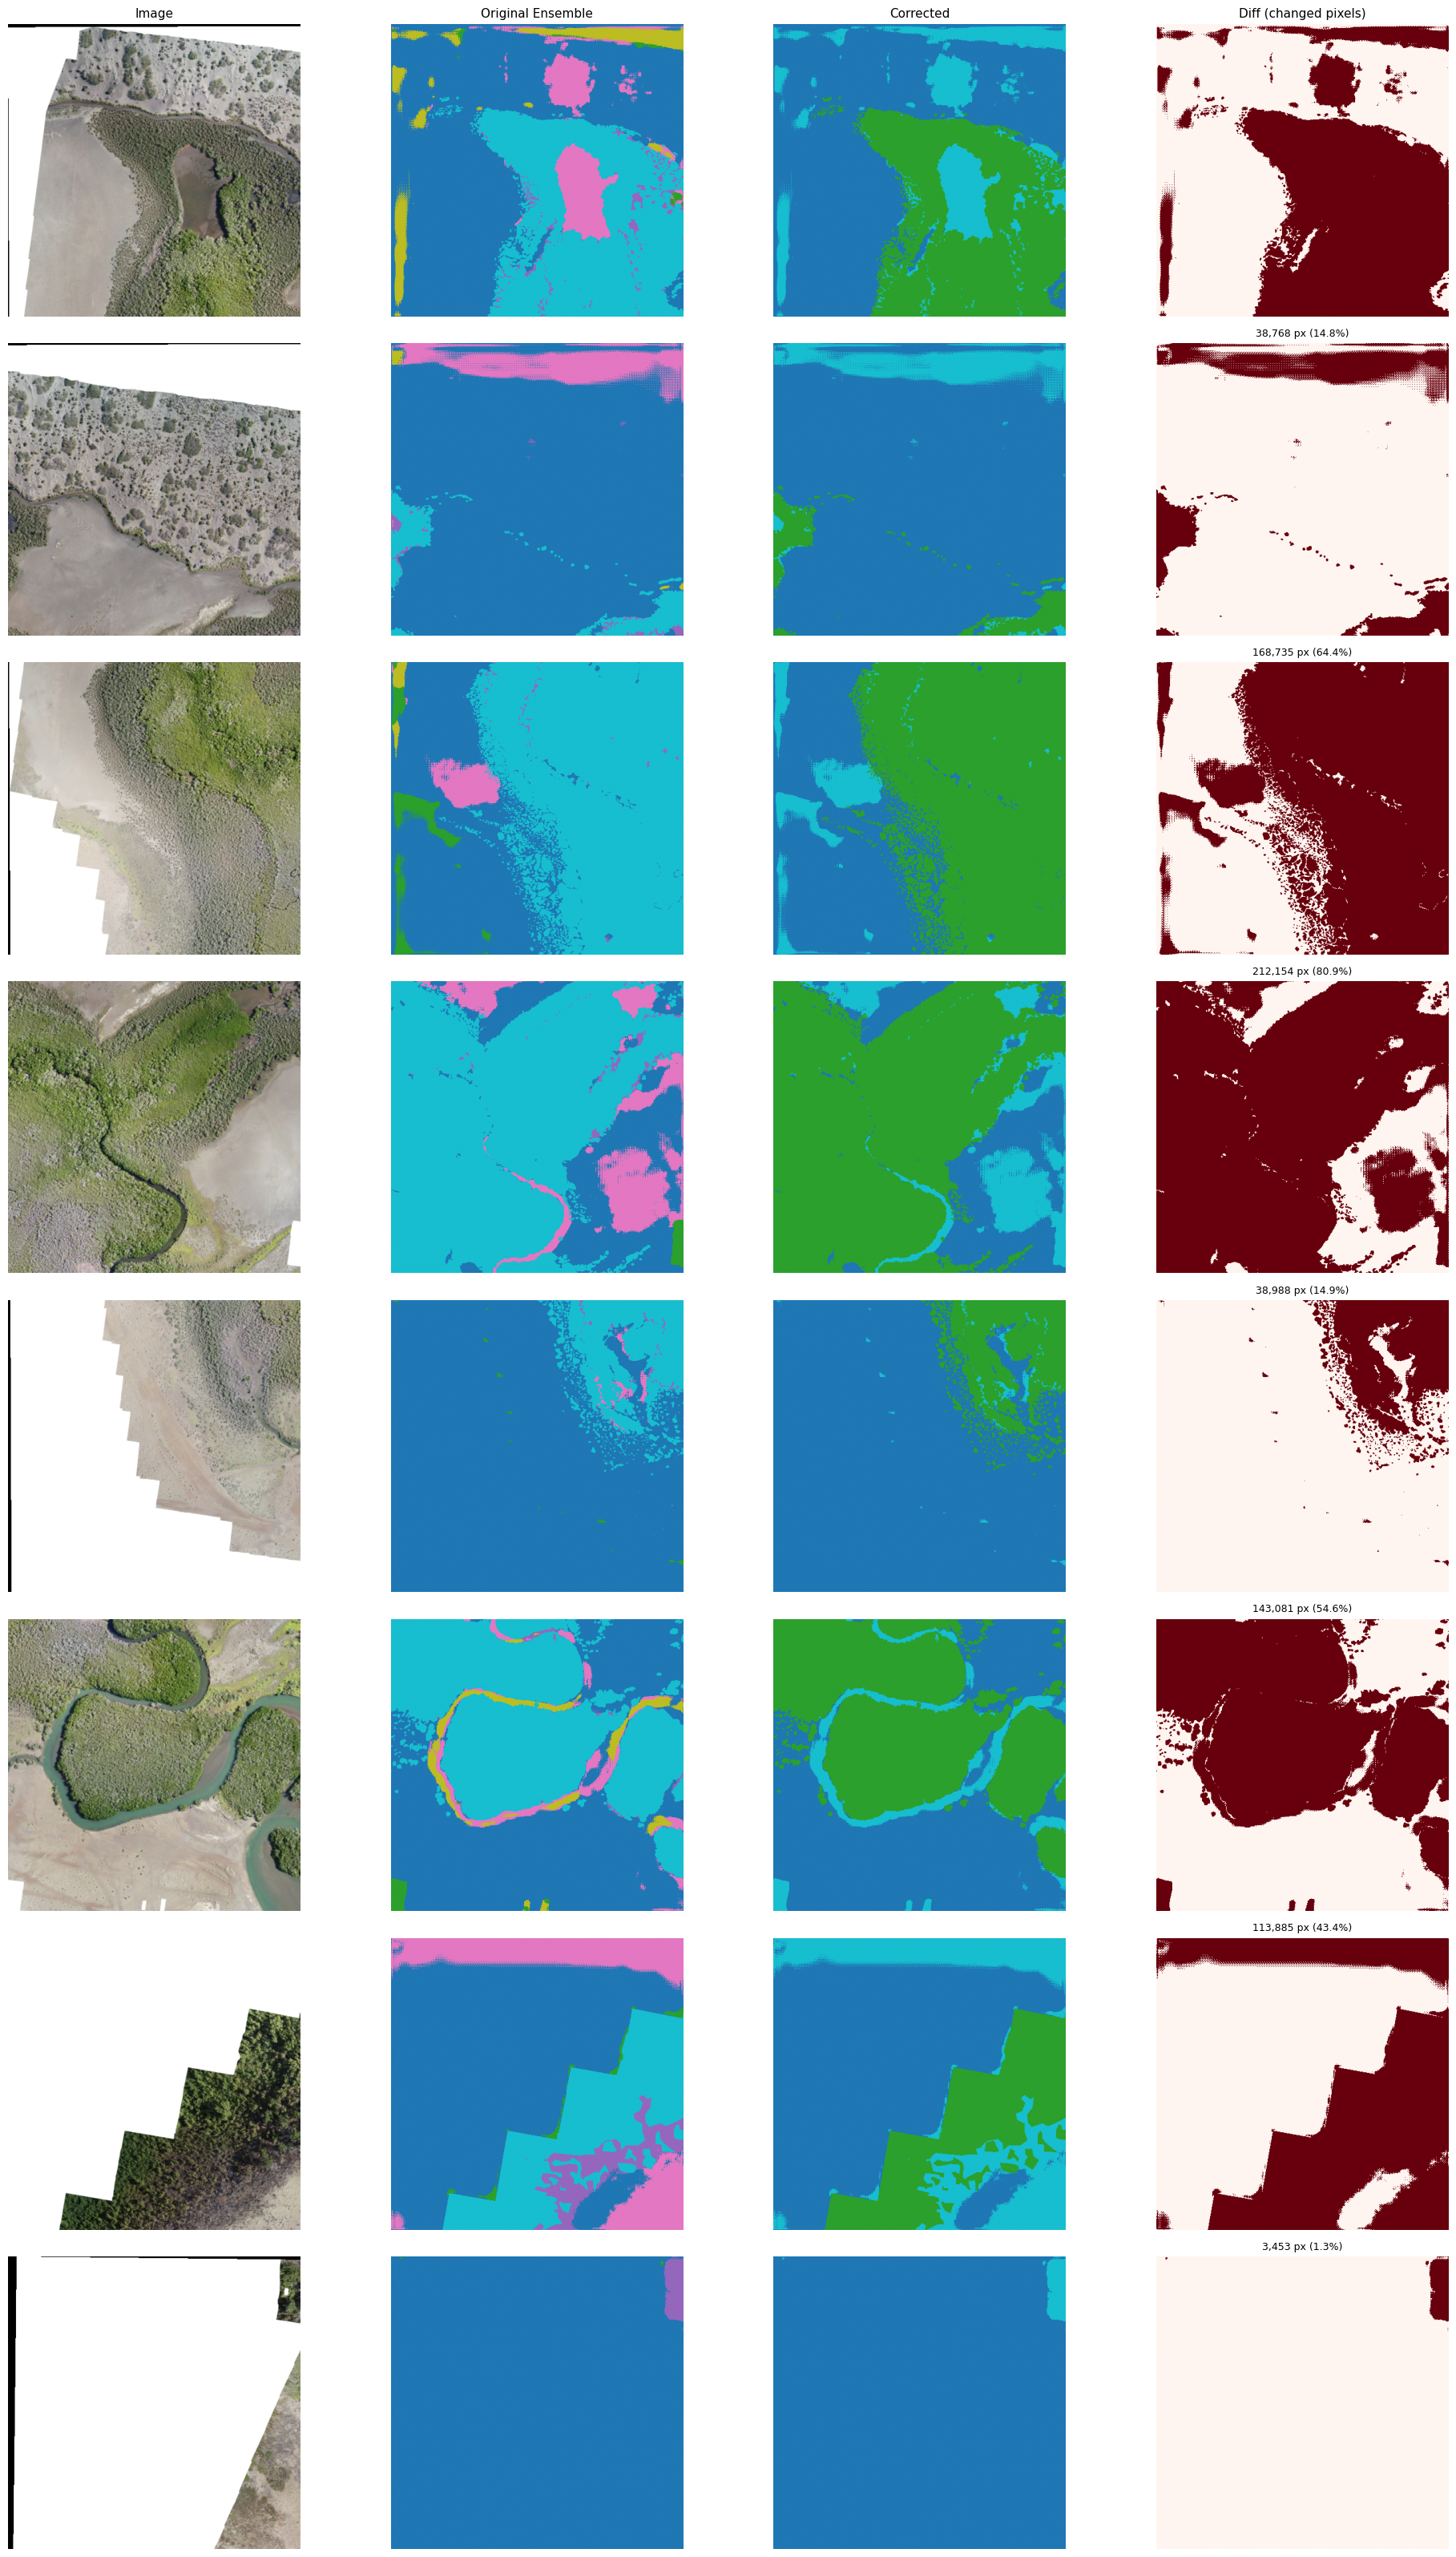


Correction summary (10 tiles):
  tile_00000: 125,270 pixels changed (47.8%)
  tile_00001: 38,768 pixels changed (14.8%)
  tile_00002: 168,735 pixels changed (64.4%)
  tile_00003: 212,154 pixels changed (80.9%)
  tile_00004: 38,988 pixels changed (14.9%)
  tile_00005: 143,081 pixels changed (54.6%)
  tile_00006: 113,885 pixels changed (43.4%)
  tile_00007:  3,453 pixels changed (1.3%)
  tile_00008: 132,367 pixels changed (50.5%)
  tile_00009: 74,570 pixels changed (28.4%)


In [6]:
# Reload original ensemble masks (before corrections) for comparison
original_ensemble = {}
with zipfile.ZipFile(ENSEMBLE_ZIP, 'r') as zf:
    for entry in zf.namelist():
        if "SegmentationClass/" in entry and entry.endswith(".png"):
            name = Path(entry).stem
            mask = np.array(Image.open(zf.open(entry)))
            if mask.ndim == 3:
                mask = mask[:, :, 0]
            original_ensemble[name] = mask

# Get corrected tile names
corrected_names = sorted([f.stem for f in corrected_files]) if corrected_files else []

if not corrected_names:
    print("No corrected masks to compare.")
else:
    n_show = min(len(corrected_names), 8)
    fig, axes = plt.subplots(n_show, 4, figsize=(20, 4 * n_show))
    if n_show == 1:
        axes = axes[np.newaxis, :]
    
    col_titles = ['Image', 'Original Ensemble', 'Corrected', 'Diff (changed pixels)']
    
    for row, name in enumerate(corrected_names[:n_show]):
        idx = tile_names.index(name)
        
        # Image
        img = images[idx]
        if img.shape[0] == 3:
            img = img.transpose(1, 2, 0)
        axes[row, 0].imshow(img)
        axes[row, 0].set_ylabel(name, fontsize=9)
        axes[row, 0].axis('off')
        
        # Original ensemble
        orig = original_ensemble[name]
        axes[row, 1].imshow(orig, vmin=0, vmax=5, cmap='tab10')
        axes[row, 1].axis('off')
        
        # Corrected
        corr = labels_array[idx, 0]
        axes[row, 2].imshow(corr, vmin=0, vmax=5, cmap='tab10')
        axes[row, 2].axis('off')
        
        # Diff: highlight pixels that changed
        diff = orig != corr
        n_changed = diff.sum()
        pct_changed = n_changed / diff.size * 100
        axes[row, 3].imshow(diff, cmap='Reds')
        axes[row, 3].set_title(f'{n_changed:,} px ({pct_changed:.1f}%)', fontsize=9)
        axes[row, 3].axis('off')
        
        if row == 0:
            for col, title in enumerate(col_titles):
                axes[row, col].set_title(title, fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Summary stats
    print(f"\nCorrection summary ({len(corrected_names)} tiles):")
    for name in corrected_names:
        orig = original_ensemble[name]
        idx = tile_names.index(name)
        corr = labels_array[idx, 0]
        diff = orig != corr
        print(f"  {name}: {diff.sum():>6,} pixels changed ({diff.sum()/diff.size*100:.1f}%)")